Streaming output truncated to the last 5000 lines.
Epoch 1: saving model to checkpoints/dqn_model_01.weights.h5
1/1 [==============================] - 0s 24ms/step

Epoch 1: saving model to checkpoints/dqn_model_01.weights.h5
1/1 [==============================] - 0s 23ms/step

Epoch 1: saving model to checkpoints/dqn_model_01.weights.h5
1/1 [==============================] - 0s 24ms/step

Epoch 1: saving model to checkpoints/dqn_model_01.weights.h5
1/1 [==============================] - 0s 23ms/step

Epoch 1: saving model to checkpoints/dqn_model_01.weights.h5
1/1 [==============================] - 0s 24ms/step

Epoch 1: saving model to checkpoints/dqn_model_01.weights.h5
1/1 [==============================] - 0s 25ms/step

Epoch 1: saving model to checkpoints/dqn_model_01.weights.h5
1/1 [==============================] - 0s 24ms/step

Epoch 1: saving model to checkpoints/dqn_model_01.weights.h5
1/1 [==============================] - 0s 24ms/step

Epoch 1: saving model to checkpoints/

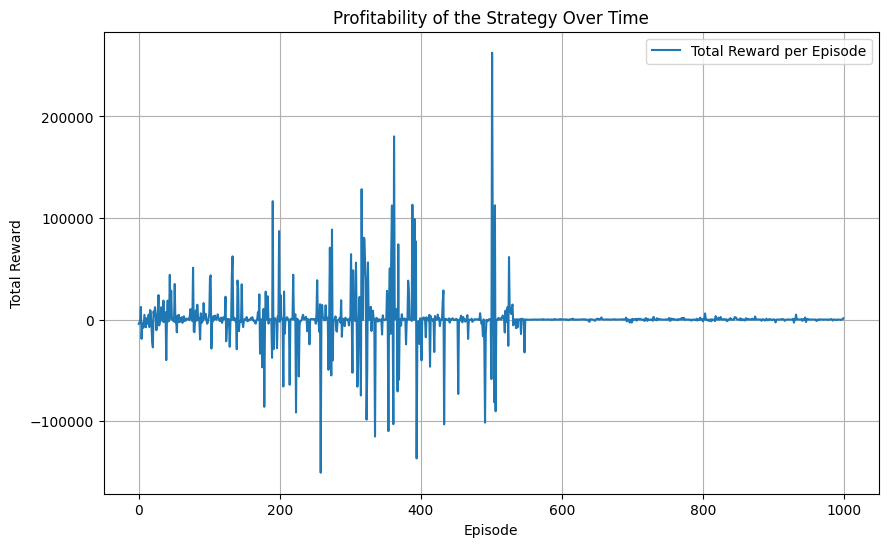

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from collections import deque
import random
import gym
from gym import spaces
import matplotlib.pyplot as plt

class TradingEnv(gym.Env):
    """A simple trading environment for a single asset."""

    def __init__(self):
        super(TradingEnv, self).__init__()

        # Define action and observation space
        # Actions: 0 = Hold, 1 = Buy, 2 = Sell
        self.action_space = spaces.Discrete(3)

        # Observation space: [current_price, cash_in_hand, asset_held]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(3,), dtype=np.float32)

        # Initial conditions
        self.initial_cash = 10000  # Starting with $10,000
        self.reset()

        self.current_step = 0
        self.max_steps = 200

    def reset(self):
        """Reset the state of the environment to an initial state."""
        self.asset_price = 100
        self.asset_held = 0
        self.cash_in_hand = self.initial_cash
        self.current_step = 0
        return self._get_observation()

    def _get_observation(self):
        """Return the current observation."""
        return np.array([self.asset_price, self.cash_in_hand, self.asset_held], dtype=np.float32)

    def step(self, action):
        """Execute one time step within the environment."""
        self.current_step += 1

        # Simulate asset price change (random walk)
        self.asset_price += np.random.normal(0, 1)
        self.asset_price = max(self.asset_price, 1)  # Ensure price doesn't go below 1

        # Execute actions: 0=hold, 1=buy, 2=sell
        if action == 1:  # Buy
            if self.cash_in_hand >= self.asset_price:
                self.cash_in_hand -= self.asset_price
                self.asset_held += 1

        elif action == 2:  # Sell
            if self.asset_held > 0:
                self.cash_in_hand += self.asset_price
                self.asset_held -= 1

        # Calculate reward: Net worth (cash + assets)
        net_worth = self.cash_in_hand + self.asset_held * self.asset_price
        reward = net_worth - self.initial_cash

        # Check if episode is done
        done = self.current_step >= self.max_steps

        return self._get_observation(), reward, done, {}

    def render(self, mode='human', close=False):
        """Render the environment to the screen."""
        net_worth = self.cash_in_hand + self.asset_held * self.asset_price
        print(f'Step: {self.current_step}')
        print(f'Asset Price: {self.asset_price:.2f}')
        print(f'Cash in Hand: {self.cash_in_hand:.2f}')
        print(f'Asset Held: {self.asset_held}')
        print(f'Net Worth: {net_worth:.2f}')

    def close(self):
        """Close the environment."""
        pass


class DQNAgent:
    def __init__(self, state_size, action_size, checkpoint_dir='checkpoints/'):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

        # Checkpointing
        self.checkpoint_dir = checkpoint_dir
        self.checkpoint = ModelCheckpoint(
            filepath=self.checkpoint_dir + 'dqn_model_{epoch:02d}.weights.h5',  # Updated extension
            save_weights_only=True,
            save_freq='epoch',
            verbose=1
        )

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Input(shape=(self.state_size,)))
        model.add(tf.keras.layers.Dense(24, activation='relu'))
        model.add(tf.keras.layers.Dense(24, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                t = self.target_model.predict(next_state)[0]
                target[0][action] = reward + self.gamma * np.amax(t)
            self.model.fit(state, target, epochs=1, verbose=0, callbacks=[self.checkpoint])
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


if __name__ == "__main__":
    env = TradingEnv()

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    episodes = 1000
    batch_size = 32

    # Results storage
    results = []

    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        total_reward = 0
        total_steps = 0

        for time in range(env.max_steps):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            total_steps += 1

            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            if done:
                print(f"Episode: {e+1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")
                break

        # Train after each episode, using the entire memory of the episode
        agent.replay(batch_size)
        agent.update_target_model()

        # Store results for analysis
        results.append(total_reward)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(results, label='Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Profitability of the Strategy Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


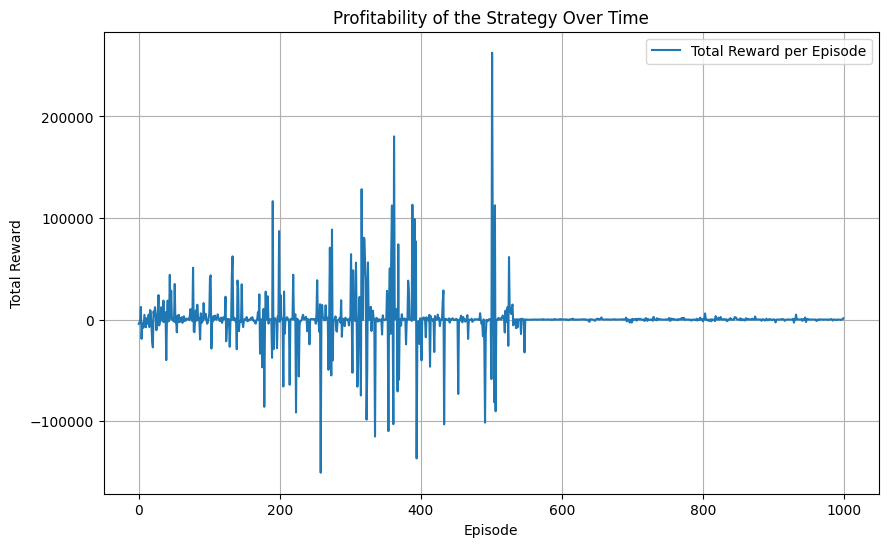

In [ ]:
import matplotlib.pyplot as plt

# Assuming the 'results' list is still in memory
plt.figure(figsize=(10, 6))
plt.plot(results, label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Profitability of the Strategy Over Time')
plt.legend()
plt.grid(True)
plt.show()

Total Episodes: 1000
Profitable Trades: 436
Unprofitable Trades: 564
Average Profit: 8879.52
Average Loss: -6263.33
Median Reward: 0.00
Standard Deviation of Rewards: 22662.59


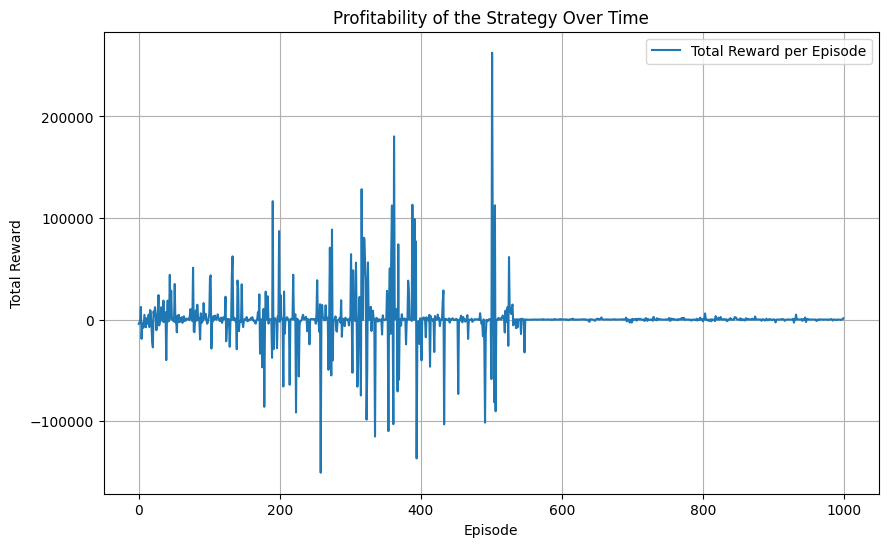

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the 'results' list is still in memory
results = np.array(results)

# Descriptive statistics
total_episodes = len(results)
profitable_trades = np.sum(results > 0)
unprofitable_trades = np.sum(results <= 0)
average_profit = np.mean(results[results > 0]) if profitable_trades > 0 else 0
average_loss = np.mean(results[results <= 0]) if unprofitable_trades > 0 else 0
median_reward = np.median(results)
std_dev_reward = np.std(results)

# Print the descriptive statistics
print(f"Total Episodes: {total_episodes}")
print(f"Profitable Trades: {profitable_trades}")
print(f"Unprofitable Trades: {unprofitable_trades}")
print(f"Average Profit: {average_profit:.2f}")
print(f"Average Loss: {average_loss:.2f}")
print(f"Median Reward: {median_reward:.2f}")
print(f"Standard Deviation of Rewards: {std_dev_reward:.2f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(results, label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Profitability of the Strategy Over Time')
plt.legend()
plt.grid(True)
plt.show()


Total Episodes: 1000
Profitable Trades: 436
Unprofitable Trades: 564
Average Profit: 8879.52
Average Loss: -6263.33
Median Reward: 0.00
Standard Deviation of Rewards: 22662.59


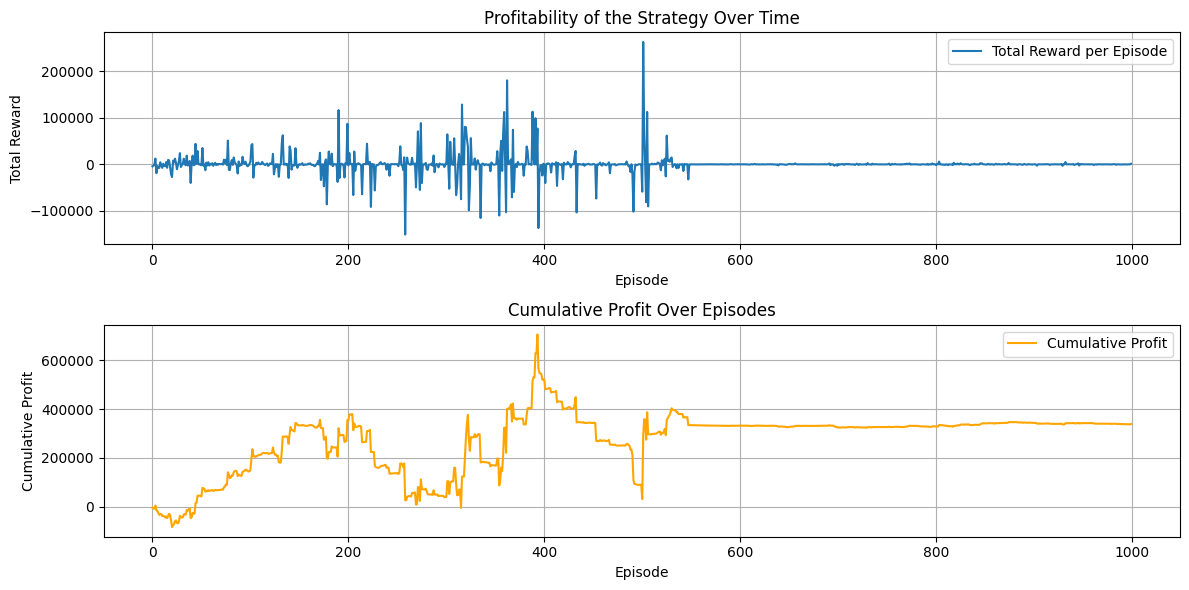

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the 'results' list is still in memory
results = np.array(results)

# Descriptive statistics
total_episodes = len(results)
profitable_trades = np.sum(results > 0)
unprofitable_trades = np.sum(results <= 0)
average_profit = np.mean(results[results > 0]) if profitable_trades > 0 else 0
average_loss = np.mean(results[results <= 0]) if unprofitable_trades > 0 else 0
median_reward = np.median(results)
std_dev_reward = np.std(results)

# Cumulative profit
cumulative_profit = np.cumsum(results)

# Print the descriptive statistics
print(f"Total Episodes: {total_episodes}")
print(f"Profitable Trades: {profitable_trades}")
print(f"Unprofitable Trades: {unprofitable_trades}")
print(f"Average Profit: {average_profit:.2f}")
print(f"Average Loss: {average_loss:.2f}")
print(f"Median Reward: {median_reward:.2f}")
print(f"Standard Deviation of Rewards: {std_dev_reward:.2f}")

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot total reward per episode
plt.subplot(2, 1, 1)
plt.plot(results, label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Profitability of the Strategy Over Time')
plt.legend()
plt.grid(True)

# Plot cumulative profit over episodes
plt.subplot(2, 1, 2)
plt.plot(cumulative_profit, label='Cumulative Profit', color='orange')
plt.xlabel('Episode')
plt.ylabel('Cumulative Profit')
plt.title('Cumulative Profit Over Episodes')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
cumulative_profit = np.sum(results)

NameError: name 'np' is not defined

In [ ]:
print(cumulative_profit)

338951.7198709614
